In [1]:
%load_ext autoreload
%autoreload 2
import os

import matplotlib.pyplot as plt
import torch
import torchsde
from torchdyn.core import NeuralODE
from torchvision import datasets, transforms
from torchvision.transforms import ToPILImage
from torchvision.utils import make_grid
from tqdm import tqdm

from torchcfm.conditional_flow_matching import *
from torchcfm.models.unet import UNetModel
from torchcfm.optimal_transport import OTPlanSampler

import numpy as np
import scipy as sp

from scipy.linalg import sqrtm

savedir = "models/mnist_entropy"
os.makedirs(savedir, exist_ok=True)

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 128
n_epochs = 10
ot_sampler = OTPlanSampler(method="exact")


In [3]:
trainset = datasets.MNIST(
    "../data",
    train=True,
    download=True,
    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]),
)

train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, drop_last=True
)

In [4]:
sigma = np.array([.15])
beta = 0.01
s = -2*beta*np.log(sigma)*(1+1.5)

std_p = lambda t,x: -np.sqrt(2*beta*np.log(x)+s)

std = sp.integrate.solve_ivp(std_p, [0,1], sigma, t_eval=np.linspace(0,1,1000),dense_output=True)

std_f = lambda t: std.sol(t).reshape(len(t))

std_prime_f = lambda t: np.sqrt(2*beta*np.log(std_f(t))+s)

/tmp/ipykernel_860116/3923312941.py:5: RuntimeWarning: invalid value encountered in log
  std_p = lambda t,x: -np.sqrt(2*beta*np.log(x)+s)
/tmp/ipykernel_860116/3923312941.py:5: RuntimeWarning: invalid value encountered in sqrt
  std_p = lambda t,x: -np.sqrt(2*beta*np.log(x)+s)


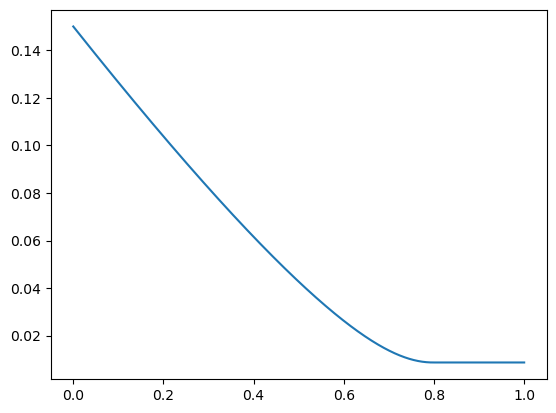

In [82]:
t = np.linspace(0,1,1000)
plt.plot(t,std_f(t))

In [83]:
std_f([1])

array([0.00871421])

In [6]:
model = UNetModel(dim=(1, 28, 28), num_channels=32, num_res_blocks=1).to(device)
optimizer = torch.optim.Adam(model.parameters())


In [85]:
for epoch in range(n_epochs):
    for data in train_loader:
    # for i, data in tqdm(enumerate(train_loader)):
        optimizer.zero_grad()
        
        x1 = data[0].to(device)
        x0 = torch.randn_like(x1)


        t = torch.rand(x0.shape[0]).type_as(x0)

        t_numpy = t.cpu().numpy()

        t = t.reshape(-1, *([1] * (x0.dim() - 1)))

        

        x0, x1 = ot_sampler.sample_plan(x0, x1)

        mu_t = ((1-t)*x0+t*x1)
        mu_t_prime = (x1-x0)

        sig_t = torch.from_numpy(std_f(t_numpy)).float().to(x0.device).unsqueeze(-1)

        sig_t = sig_t.reshape(-1, *([1] * (x0.dim() - 1)))

        sig_t_prime = torch.from_numpy(std_prime_f(t_numpy)).float().to(x0.device).unsqueeze(-1)

        sig_t_prime = sig_t_prime.reshape(-1, *([1] * (x0.dim() - 1)))
        
        epsilon = torch.randn_like(x0)

        xt = mu_t + sig_t*epsilon
        ut = sig_t_prime*(xt-mu_t)/(sig_t+1e-8) + mu_t_prime


        vt = model(t, xt)
        loss = torch.mean((vt - ut) ** 2)
        loss.backward()
        optimizer.step()

torch.Size([128, 1, 1, 1])
torch.Size([128, 1, 1])
torch.Size([128, 1])
torch.Size([128, 1, 1, 1])
torch.Size([128, 1, 1])
torch.Size([128, 1])
torch.Size([128, 1, 1, 1])
torch.Size([128, 1, 1])
torch.Size([128, 1])
torch.Size([128, 1, 1, 1])
torch.Size([128, 1, 1])
torch.Size([128, 1])
torch.Size([128, 1, 1, 1])
torch.Size([128, 1, 1])
torch.Size([128, 1])
torch.Size([128, 1, 1, 1])
torch.Size([128, 1, 1])
torch.Size([128, 1])
torch.Size([128, 1, 1, 1])
torch.Size([128, 1, 1])
torch.Size([128, 1])
torch.Size([128, 1, 1, 1])
torch.Size([128, 1, 1])
torch.Size([128, 1])
torch.Size([128, 1, 1, 1])
torch.Size([128, 1, 1])
torch.Size([128, 1])
torch.Size([128, 1, 1, 1])
torch.Size([128, 1, 1])
torch.Size([128, 1])
torch.Size([128, 1, 1, 1])
torch.Size([128, 1, 1])
torch.Size([128, 1])
torch.Size([128, 1, 1, 1])
torch.Size([128, 1, 1])
torch.Size([128, 1])
torch.Size([128, 1, 1, 1])
torch.Size([128, 1, 1])
torch.Size([128, 1])
torch.Size([128, 1, 1, 1])
torch.Size([128, 1, 1])
torch.Size([1

In [7]:
model.load_state_dict(torch.load(os.path.join(savedir, "model.pt")))

<All keys matched successfully>

In [8]:
model.eval()

UNetModelWrapper(
  (time_embed): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): SiLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
  (input_blocks): ModuleList(
    (0): TimestepEmbedSequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): TimestepEmbedSequential(
      (0): ResBlock(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 32, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (h_upd): Identity()
        (x_upd): Identity()
        (emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=128, out_features=32, bias=True)
        )
        (out_layers): Sequential(
          (0): GroupNorm32(32, 32, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Dropout(p=0, inplace=False)
          (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(

In [13]:
N1 = 50
N2 = 50
t_f = 0.75
N = N1+N2
t1 = torch.linspace(0, t_f, N1).to(device)
t2 = torch.linspace(t_f+0.01,1,N2).to(device)
t = torch.cat([t1,t2]).to(device)
t = torch.linspace(0,1,N).to(device)

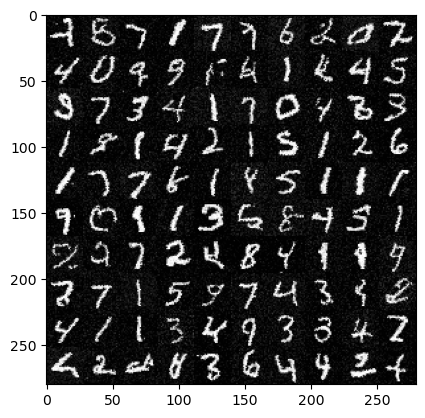

In [14]:
node = NeuralODE(model, solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4)
# Evaluate the ODE
with torch.no_grad():
    traj = node.trajectory(
        torch.randn(100, 1, 28, 28).to(device),
        t_span=t,
    )
grid = make_grid(
    traj[-1, :100].view([-1, 1, 28, 28]).clip(-1, 1), value_range=(-1, 1), padding=0, nrow=10
)
img = ToPILImage()(grid)
plt.imshow(img)

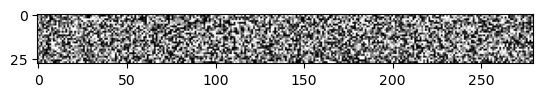

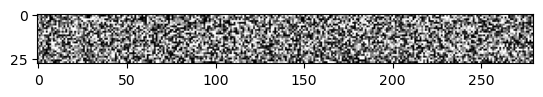

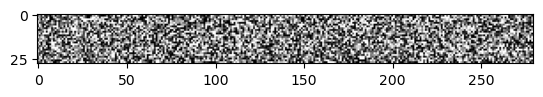

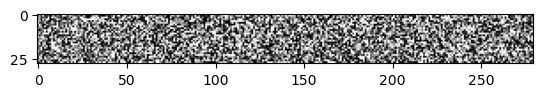

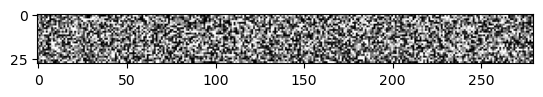

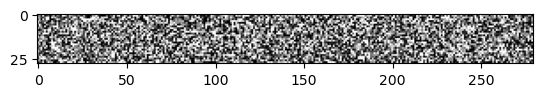

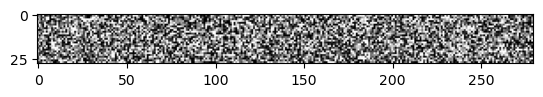

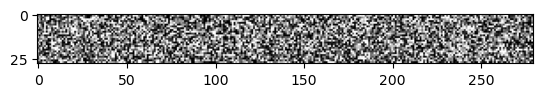

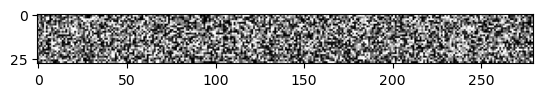

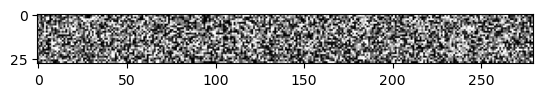

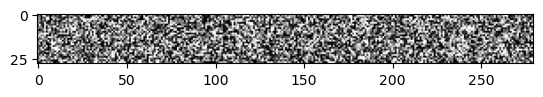

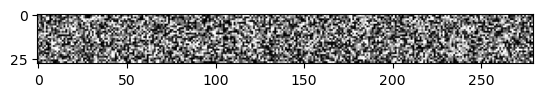

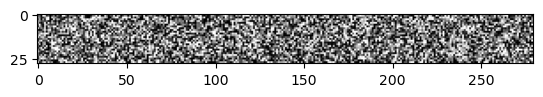

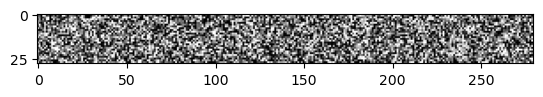

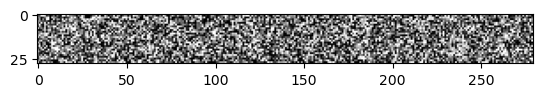

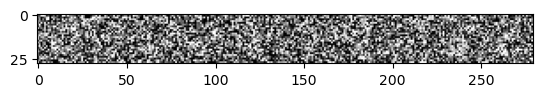

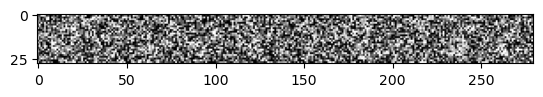

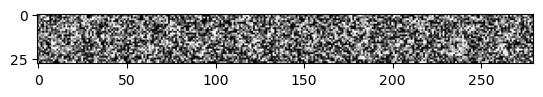

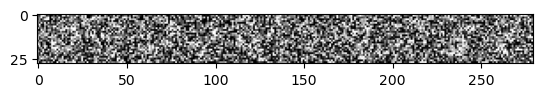

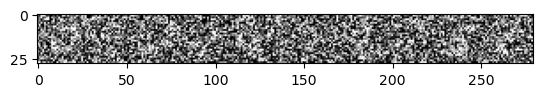

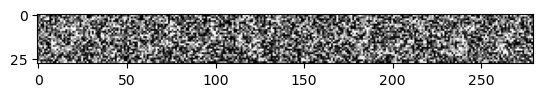

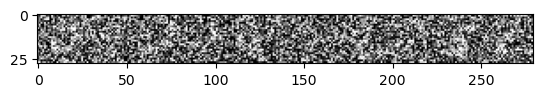

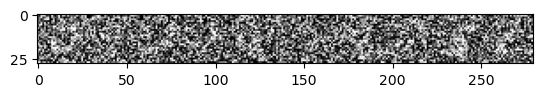

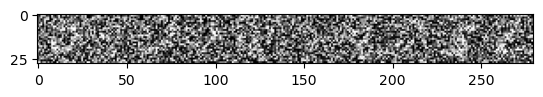

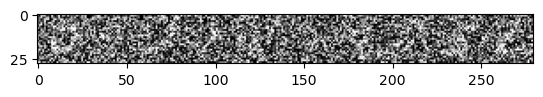

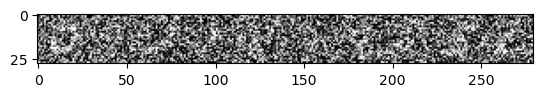

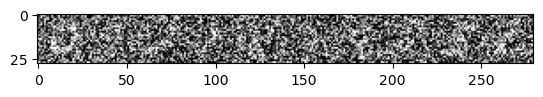

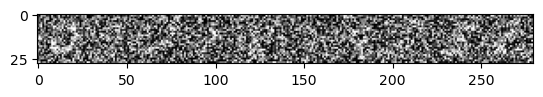

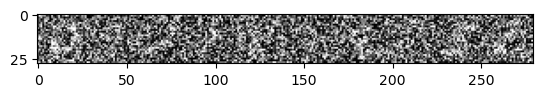

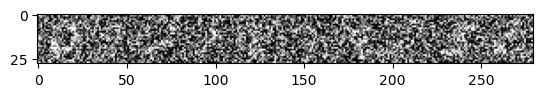

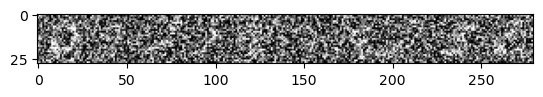

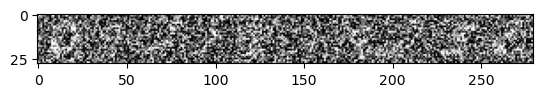

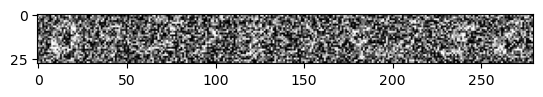

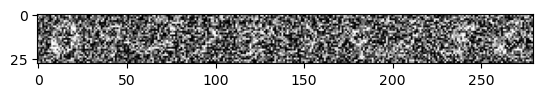

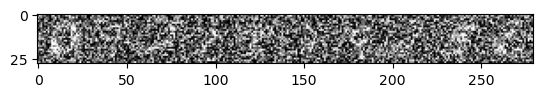

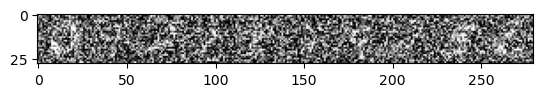

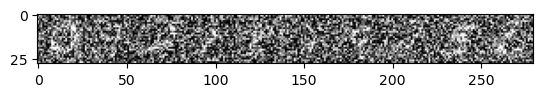

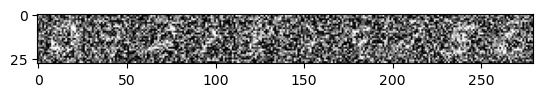

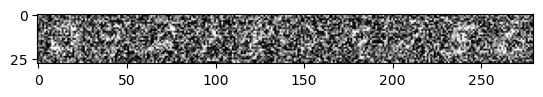

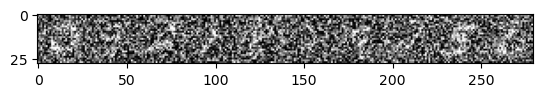

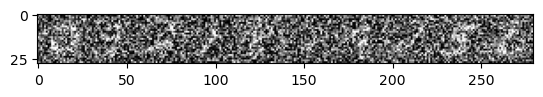

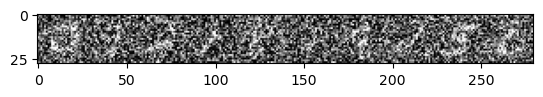

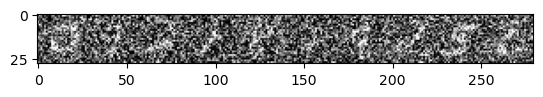

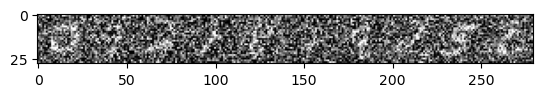

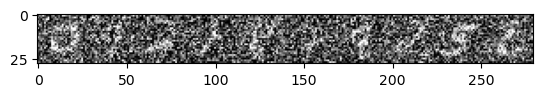

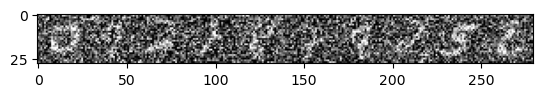

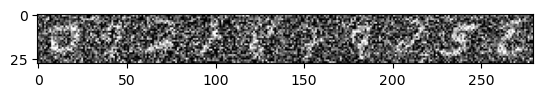

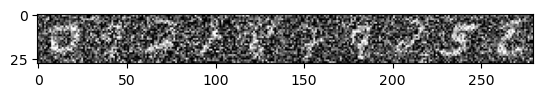

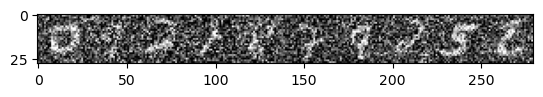

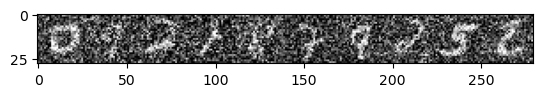

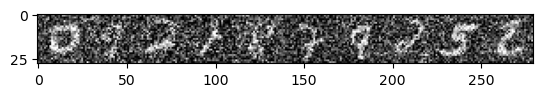

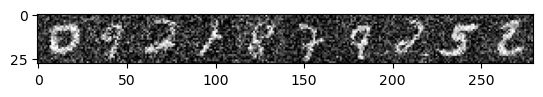

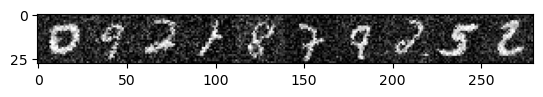

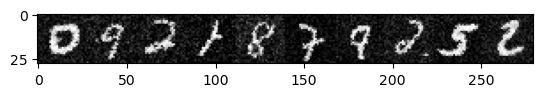

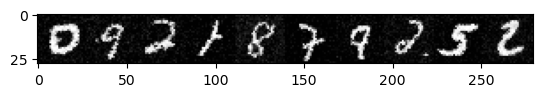

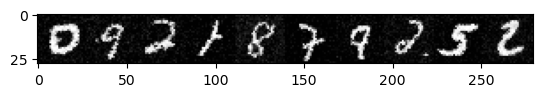

In [107]:
# N1 = 100
# N2 = 50
# N = N1+N2
k = N//N
# t1 = torch.linspace(0, 0.15, N1).to(device)
# t2 = torch.linspace(0.1501,1,N2).to(device)
# t = torch.cat([t1,t2]).to(device)
with torch.no_grad():
    traj = node.trajectory(
        torch.randn(10, 1, 28, 28).to(device),
        t_span=t,
    )
for i in range(0,N,k):
    grid = make_grid(
        traj[i, :100].view([-1, 1, 28, 28]).clip(-1, 1), value_range=(-1, 1), padding=0, nrow=10
    )
    img = ToPILImage()(grid)
    plt.imshow(img)
    plt.show() 

grid = make_grid(
    traj[-1, :100].view([-1, 1, 28, 28]).clip(-1, 1), value_range=(-1, 1), padding=0, nrow=10
)
img = ToPILImage()(grid)
plt.imshow(img)

In [98]:
torch.save(model.state_dict(), os.path.join(savedir, "model.pt"))

In [49]:
# Generated by copilot WITHOUT SUPERVISION NEED TO CHECK
# Function to calculate activations
def calculate_activations(images):
    if images.device != torch.device('cuda'):
        images = images.cuda()
    with torch.no_grad():
        activations = model(images)
    return activations.cpu()

# Function to calculate mean and covariance
def calculate_mean_and_covariance(activations):
    mu = torch.mean(activations, dim=0)
    sigma = torch_cov(activations, rowvar=False)
    return mu, sigma

# Function to calculate covariance
def torch_cov(m, rowvar=False):
    if m.dim() > 2:
        raise ValueError('m has more than 2 dimensions')
    if m.dim() < 2:
        m = m.view(1, -1)
    if not rowvar and m.size(0) != 1:
        m = m.t()
    fact = 1.0 / (m.size(1) - 1)
    m -= torch.mean(m, dim=1, keepdim=True)
    mt = m.t()  # if complex: mt = m.t().conj()
    return fact * m.matmul(mt).squeeze()

# Function to calculate Frechet distance
def calculate_frechet_distance(mu1, sigma1, mu2, sigma2):
    diff = mu1 - mu2
    covmean, _ = sqrtm(sigma1.mm(sigma2), disp=False)
    fd = (diff.dot(diff) + torch.trace(sigma1) + torch.trace(sigma2) - 2*torch.trace(covmean))
    return fd


In [53]:
# Assuming your model is named `model` and is on the same device as your data
# Also assuming you have a DataLoader `data_loader` for your real images

model.eval()

# Get a batch of real images and labels
real_images, _ = next(iter(train_loader))

# Generate a batch of fake images from your model
# The input to your model will depend on its architecture
# Here we assume a noise vector as input
noise = torch.randn(real_images.shape[0], 100).to(real_images.device)
with torch.no_grad():
    traj = node.trajectory(torch.randn(batch_size, 1, 28, 28).to(device),t_span=torch.linspace(0, 1, 100).to(device),)
fake_images = traj[-1, :100].view([-1, 1, 28, 28]).clip(-1, 1)

# Calculate FID
# activations_real = calculate_activations(real_images)
# activations_fake = calculate_activations(fake_images)
mu_real, sigma_real = calculate_mean_and_covariance(real_images)
mu_fake, sigma_fake = calculate_mean_and_covariance(fake_images)
fid = calculate_frechet_distance(mu_real, sigma_real, mu_fake, sigma_fake)

print('FID:', fid.item())

ValueError: m has more than 2 dimensions